In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from skimage.transform import hough_line, hough_line_peaks, hough_circle, hough_circle_peaks
from skimage.draw import circle_perimeter
from skimage.feature import canny
from skimage.data import astronaut
from skimage.io import imread, imsave
from skimage.color import rgb2gray, gray2rgb, label2rgb
from skimage import data, img_as_float
from skimage.morphology import skeletonize
from skimage.filters import sobel, threshold_otsu
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed, mark_boundaries, find_boundaries

### The Hough Transform

c:\Users\kipli\miniconda3\envs\images2\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
c:\Users\kipli\miniconda3\envs\images2\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in double_scalars


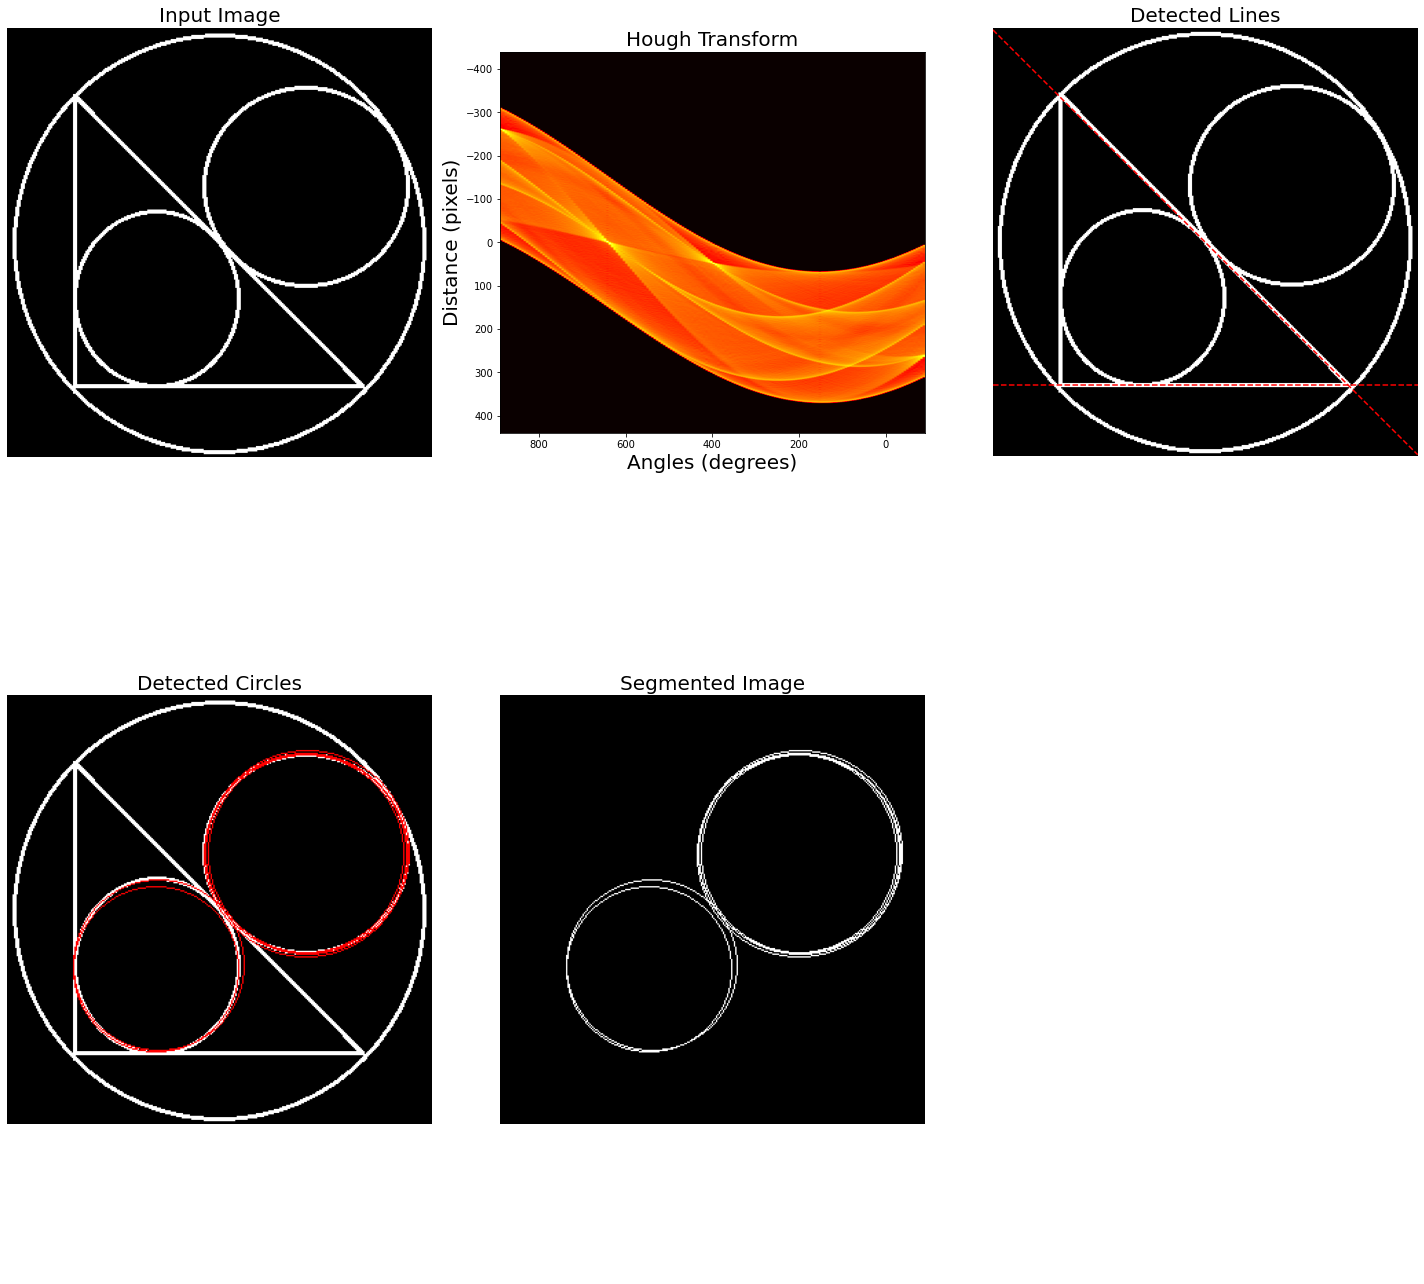

In [28]:
img  = rgb2gray(imread('images/packt_images/triangle_circle.png')[:,:,:3])

# Straight Line Hough Transform
h, theta, d = hough_line(img)
fig, axes = plt.subplots(2, 3, figsize= (20,20))
axes = axes.ravel()
axes[0].imshow(img, cm.gray)
axes[0].set_title('Input Image', size=20)
axes[0].set_axis_off()

axes[1].imshow(np.log(1 + h), extent = [10*np.rad2deg(theta[-1]), np.rad2deg(theta[0]),
                d[-1], d[0]], cmap=cm.hot, aspect=1/1.5)
axes[1].set_title('Hough Transform', size=20)
axes[1].set_xlabel('Angles (degrees)', size=20)
axes[1].set_ylabel('Distance (pixels)', size=20)
axes[1].axis('image')

axes[2].imshow(img, cmap=cm.gray)
for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
    y1 = (dist - img.shape[1] * np.cos(angle)) / np.sin(angle)
    axes[2].plot((0, img.shape[1]), (y0, y1), '--r')
axes[2].set_xlim((0, img.shape[1]))
axes[2].set_ylim((img.shape[0], 0))
axes[2].set_axis_off()
axes[2].set_title('Detected Lines', size=20)

# Circle Hough Transform
hough_radii = np.arange(50, 100, 2)
hough_res = hough_circle(img, hough_radii)
accums, c_x, c_y, radii = hough_circle_peaks(hough_res, hough_radii, total_num_peaks=6)
seg_img = np.zeros_like(img)
img = gray2rgb(img)
for y_center, x_center, radius in zip(c_y, c_x, radii):
    circ_y, circ_x = circle_perimeter(y_center, x_center, radius)
    img[circ_y, circ_x] = [1, 0, 0]
    seg_img[circ_y, circ_x] = 1
axes[3].imshow(img, cmap=plt.cm.gray)
axes[3].set_axis_off()
axes[3].set_title('Detected Circles', size=20)
axes[4].imshow(seg_img, cmap=plt.cm.gray)
axes[4].set_axis_off()
axes[4].set_title('Segmented Image', size=20)
plt.tight_layout()
plt.axis('off')
plt.show()

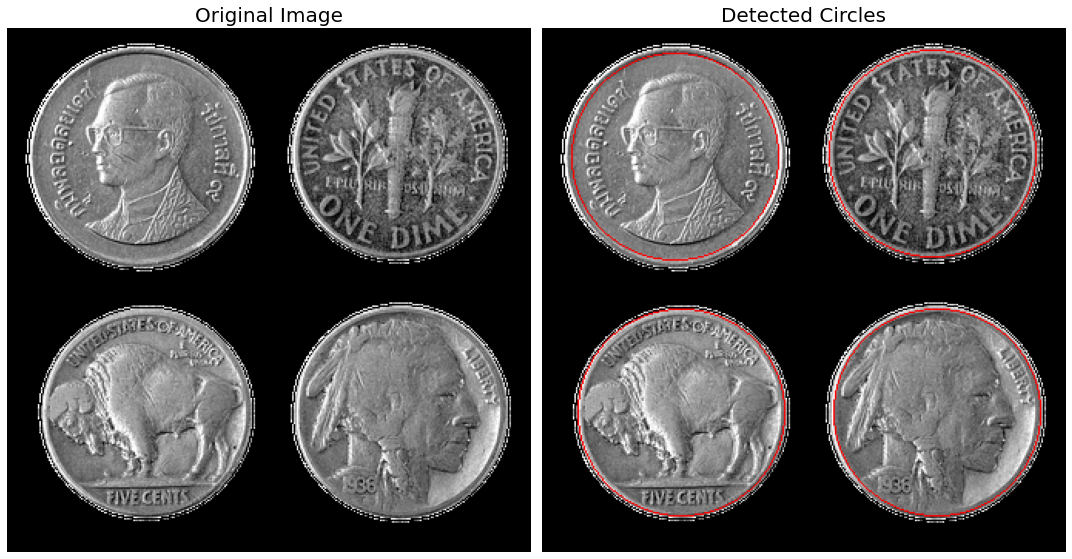

In [33]:
img = rgb2gray(imread('images/packt_images/coins.png')[:,:,:3])
fig, axes = plt.subplots(1, 2, figsize=(15, 8), sharex=True, sharey=True)
axes = axes.ravel()
axes[0].imshow(img, cmap=plt.cm.gray)
axes[0].set_axis_off()
axes[0].set_title('Original Image', size=20)

hough_radii = np.arange(65, 75, 1)
hough_res = hough_circle(img, hough_radii)
accums, c_x, c_y, radii = hough_circle_peaks(hough_res, hough_radii, total_num_peaks=4)
img = gray2rgb(img)
for center_y, center_x, radius in zip(c_y, c_x, radii):
    circ_y, circ_x = circle_perimeter(center_y, center_x, radius)
    img[circ_y, circ_x] = (1, 0, 0)
axes[1].imshow(img, cmap=plt.cm.gray)
axes[1].set_axis_off()
axes[1].set_title('Detected Circles', size=20)
plt.tight_layout()
plt.show()

### Thresholding and Otsu's Methd

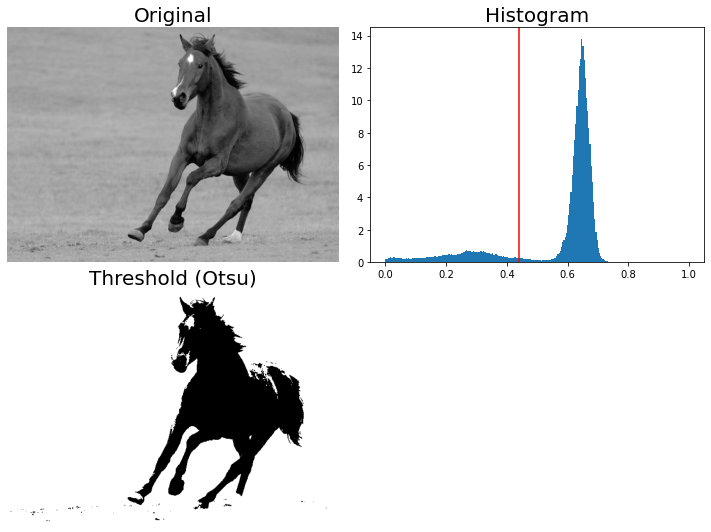

In [71]:
img = rgb2gray(imread('images/packt_images/horse.jpg'))
thresh = threshold_otsu(img)
binary = img > thresh

fig, axes = plt.subplots(2, 2, figsize=(10, 7.5))
axes = axes.ravel()
axes[0], axes[1] = plt.subplot(2, 2, 1), plt.subplot(2, 2, 2)
axes[2] = plt.subplot(2, 2, 3, sharex=axes[0], sharey=axes[0])
axes[3] = plt.subplot(2, 2, 4, sharex=axes[1], sharey=axes[0])

axes[0].imshow(img, 'gray')
axes[0].set_title('Original', size=20)
axes[0].axis('off')

axes[1].hist(img.ravel(), bins=256, density=True)
axes[1].axvline(thresh, color='r')
axes[1].set_title('Histogram', size=20)
# axes[1].axis('off')

axes[2].imshow(binary, 'gray')
axes[2].set_title('Threshold (Otsu)', size=20)
axes[2].axis('off')
axes[3].axis('off')
plt.tight_layout()
plt.show()

### Edge-Based Segmentation

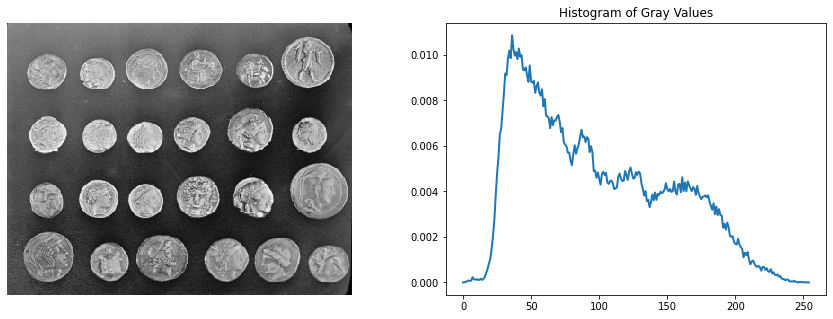

In [89]:
# intensity histogram
coins = data.coins()
hist = np.histogram(coins, bins=np.arange(0, 256), density=True)
fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].imshow(coins, cmap='gray', interpolation='nearest')
axes[0].axis('off')
axes[1].plot(hist[1][:-1], hist[0], lw=2)
axes[1].set_title('Histogram of Gray Values')
plt.show()

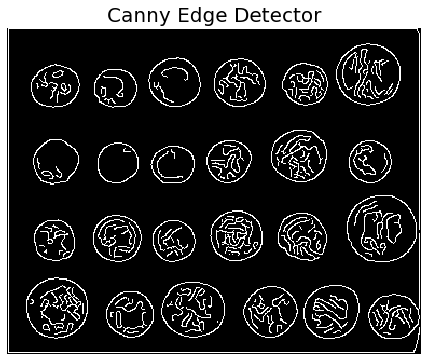

In [101]:
# Edge-based segmentation
edges = canny(coins, sigma=1.5, )
fig, axes = plt.subplots(figsize=(10, 6))
axes.imshow(edges, 'gray', interpolation='nearest')
axes.set_title('Canny Edge Detector', size=20)
axes.axis('off')
plt.show()

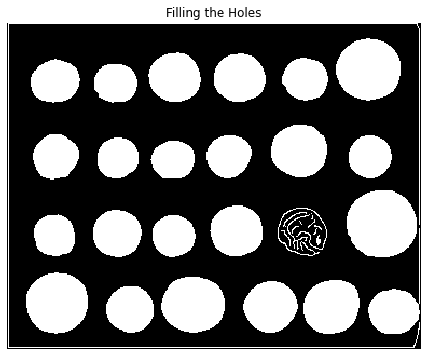

In [102]:
# filling the holes
from scipy import ndimage as ndi
fill_coins = ndi.binary_fill_holes(edges)
fig, axes = plt.subplots(figsize=(10,6))
axes.imshow(fill_coins, 'gray', interpolation='nearest')
axes.set_title('Filling the Holes')
axes.axis('off')
plt.show()

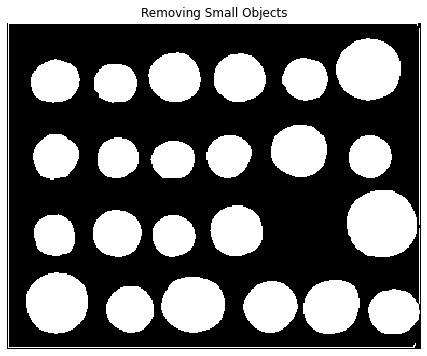

In [116]:
# removing small objects
from skimage import morphology
coins_cleaned = morphology.remove_small_objects(fill_coins, 47)
fig, axes = plt.subplots(figsize=(10, 6))
axes.imshow(coins_cleaned, 'gray', interpolation='nearest')
axes.set_title('Removing Small Objects')
axes.axis('off')
plt.show()

### Region-Based Segmentation